Eskom Dataset — Training Notebook

This notebook trains an ensemble on the Eskom CSV (ESK17311.csv).

In [ ]:
!pip install -q lightgbm joblib scikit-learn pandas matplotlib xgboost catboost --quiet
print('Install complete')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00
Install complete


In [ ]:
import os, joblib, math
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
print('Imports ready')

Imports ready


In [ ]:
# Step 1 — Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2 — Check files
!ls /content/drive/MyDrive


Mounted at /content/drive
'3c759499-e1e2-46f1-8099-006e4d1d4d95_copy (1).pdf'
 3c759499-e1e2-46f1-8099-006e4d1d4d95_copy.pdf
'ADAS '
'AIML KUPAKWASHE MAPURANGA PPT.pptx'
'assign1&2 qns.pdf'
'Assignment 8_2.ipynb'
'bath2 kupakwahse Mapuranga hostel services sandip university.zip'
 cat.csv
'certificate (1).pdf'
 Classroom
'Colab Notebooks'
'Comprehension Passage 2.gdoc'
'Copy of Data Importing.ipynb'
'Course Structure and Syllabus_FE_2018-19 (1).gdoc'
'CV reviewed India.pdf'
'Data analytics using excel.pptx'
 dog.csv
 EDAV
'ENGLISH PPT'
 ER_Diagram1.xml
'Getting started.pdf'
 InteractiveSheet_2025-08-26_10_06_39.gsheet
'Internship Letter 1.pdf'
'KTM Resume2.pdf'
'KTM resume & passport.pdf'
'kupa new passport_compressed (2).pdf'
'Mr. Kupakwashe Tinotenda Mapuranga.pdf'
'My certificates'
'OOP lab Practical Exam Kupakwashe Mapuranga AIML.pdf'
'opp lab 2.png'
'physics assign 4.pdf'
'PPT Format for CIA3 (1).gslides'
'PPT Format for CIA3.gslides'
'prof b work'
'reference for workshop write up.

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/SEMS/ESK17311.csv"
df = pd.read_csv(file_path)
print("Shape:", df.shape)
df.head()

Shape: (43824, 5)


,Date Time Hour Beginning,Residual Forecast,RSA Contracted Forecast,Residual Demand,ILS Usage
0,2021-04-01 12:00:00 AM,21076.232,21833.271,21177.801,0.0
1,2021-04-01 01:00:00 AM,20803.317,21453.623,20886.668,0.0
2,2021-04-01 02:00:00 AM,20752.810,21284.327,20822.775,0.0
3,2021-04-01 03:00:00 AM,20871.016,21396.662,21068.201,0.0
4,2021-04-01 04:00:00 AM,22089.175,22639.893,22216.935,0.0


In [ ]:
# Inspect and standardize columns
cols = [c.strip() for c in df.columns]
df.columns = cols
print('Columns:', df.columns.tolist())

if 'Date Time Hour Beginning' not in df.columns:
    raise SystemExit("Missing 'Date Time Hour Beginning' column")
if 'Residual Demand' not in df.columns:
    raise SystemExit("Missing 'Residual Demand' column")

# parse timestamp
df['timestamp'] = pd.to_datetime(df['Date Time Hour Beginning'], errors='coerce')
df['residual_demand'] = pd.to_numeric(df['Residual Demand'], errors='coerce')

# set timestamp as index for time-based operations
df = df.dropna(subset=['timestamp'])
print('After parse shape:', df.shape)
df[['timestamp','residual_demand']].head()

Columns: ['Date Time Hour Beginning', 'Residual Forecast', 'RSA Contracted Forecast', 'Residual Demand', 'ILS Usage', 'residual_demand']


/tmp/ipython-input-4118535856.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['Date Time Hour Beginning'], errors='coerce')


After parse shape: (43824, 7)


,timestamp,residual_demand
timestamp,,
2021-04-01 00:00:00,2021-04-01 00:00:00,21177.801
2021-04-01 01:00:00,2021-04-01 01:00:00,20886.668
2021-04-01 02:00:00,2021-04-01 02:00:00,20822.775
2021-04-01 03:00:00,2021-04-01 03:00:00,21068.201
2021-04-01 04:00:00,2021-04-01 04:00:00,22216.935


In [ ]:
# Impute missing target values if any
df = df.set_index('timestamp')
if df['residual_demand'].isna().sum() > 0:
    df['residual_demand'] = df['residual_demand'].interpolate(method='time')
    df['residual_demand'] = df['residual_demand'].fillna(method='ffill').fillna(method='bfill')

# sort
df = df.sort_values('timestamp').reset_index()
print('Nulls after imputation:', df['residual_demand'].isna().sum())

Nulls after imputation: 0


/tmp/ipython-input-2092669993.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['residual_demand'] = df['residual_demand'].fillna(method='ffill').fillna(method='bfill')


In [ ]:
# Aggregate hourly to daily totals
df['date'] = df['timestamp'].dt.normalize()
daily = df.groupby('date', as_index=False)['residual_demand'].sum().rename(columns={'residual_demand':'daily_consumption'})
daily['timestamp'] = pd.to_datetime(daily['date'])
train_df = daily[['timestamp','daily_consumption']].sort_values('timestamp').reset_index(drop=True)
print('Daily rows:', len(train_df))
train_df.head()

Daily rows: 1826


,timestamp,daily_consumption
0,2021-04-01,575373.605
1,2021-04-02,531735.445
2,2021-04-03,522649.684
3,2021-04-04,520491.341
4,2021-04-05,526225.147


In [ ]:
# Feature engineering
train_df['day_of_week'] = train_df['timestamp'].dt.weekday
train_df['day_of_month'] = train_df['timestamp'].dt.day
train_df['month'] = train_df['timestamp'].dt.month
for w in [3,7,14]:
    train_df[f'rolling_avg_{w}'] = train_df['daily_consumption'].shift(1).rolling(window=w, min_periods=1).mean()
for lag in [1,2,7]:
    train_df[f'lag_{lag}'] = train_df['daily_consumption'].shift(lag)
train_df = train_df.dropna().reset_index(drop=True)
print('After FE:', train_df.shape)
train_df.head()

After FE: (1819, 11)


,timestamp,daily_consumption,day_of_week,day_of_month,month,rolling_avg_3,rolling_avg_7,rolling_avg_14,lag_1,lag_2,lag_7
0,2021-04-08,602202.473,3,8,4,569767.881667,551364.817143,551364.817143,600185.097,582893.401,575373.605
1,2021-04-09,595503.560,4,9,4,595093.657000,555197.512571,557719.524125,602202.473,600185.097,531735.445
2,2021-04-10,565583.323,5,10,4,599297.043333,564307.243286,561917.750333,595503.560,602202.473,522649.684
3,2021-04-11,558679.899,6,11,4,587763.118667,570440.620286,562284.307600,565583.323,595503.560,520491.341
4,2021-04-12,599811.511,0,12,4,573255.594000,575896.128571,561956.634091,558679.899,565583.323,526225.147


In [ ]:
# Prepare features and time split
TARGET = 'daily_consumption'
features = [c for c in train_df.columns if c not in ['timestamp', TARGET]]
split_idx = int(len(train_df) * 0.8)
X_train, X_test = train_df[features].iloc[:split_idx], train_df[features].iloc[split_idx:]
y_train, y_test = train_df[TARGET].iloc[:split_idx], train_df[TARGET].iloc[split_idx:]
print('Train/Test shapes:', X_train.shape, X_test.shape)

Train/Test shapes: (1455, 9) (364, 9)


In [ ]:
# Train stacking pipeline
estimators = [
    ('lgbm', lgb.LGBMRegressor(n_estimators=300, random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators=200, tree_method='hist', use_label_encoder=False, eval_metric='rmse', random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
]
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor



Fitting...
Done


In [ ]:
stack = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=1.0), cv=5, n_jobs=-1)
pipe = Pipeline([('scaler', StandardScaler()), ('stack', stack)])


pipe.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE: 28617.603439316357
RMSE: 1175920977.5300765
R2: 0.7022727661730329


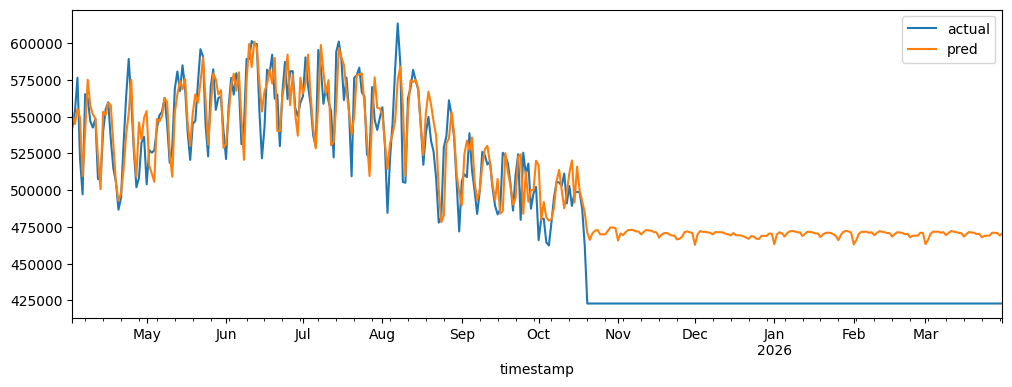

In [ ]:
# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
preds = pipe.predict(X_test)
print('MAE:', mean_absolute_error(y_test, preds))
print('RMSE:', mean_squared_error(y_test, preds))
print('R2:', r2_score(y_test, preds))

# Plot
try:
    comp = pd.DataFrame({'timestamp': train_df['timestamp'].iloc[split_idx:].values, 'actual': y_test.values, 'pred': preds})
    comp.set_index('timestamp', inplace=True)
    comp[['actual','pred']].plot(figsize=(12,4));
    plt.show()
except Exception:
    pass

In [ ]:
# Save model
OUT='energy_model_eskom.joblib'
joblib.dump(pipe, OUT)
print('Saved', OUT)
try:
    from google.colab import files
    files.download(OUT)
except Exception:
    print('Model saved in working dir')

Raw target summary (first 10 rows):
            timestamp  residual_demand
0 2021-04-01 00:00:00        21177.801
1 2021-04-01 01:00:00        20886.668
2 2021-04-01 02:00:00        20822.775
3 2021-04-01 03:00:00        21068.201
4 2021-04-01 04:00:00        22216.935
5 2021-04-01 05:00:00        24275.534
6 2021-04-01 06:00:00        25935.668
7 2021-04-01 07:00:00        25794.668
8 2021-04-01 08:00:00        25819.534
9 2021-04-01 09:00:00        25121.247

Full describe():
count    43824.000000
mean     22946.783337
std       3157.448206
min      15634.673000
25%      20656.138500
50%      22959.120500
75%      25234.243250
max      34029.030000
Name: residual_demand, dtype: float64

Daily sample (sum & mean):
        date   daily_sum    daily_mean
0 2021-04-01  575373.605  23973.900208
1 2021-04-02  531735.445  22155.643542
2 2021-04-03  522649.684  21777.070167
3 2021-04-04  520491.341  21687.139208
4 2021-04-05  526225.147  21926.047792
5 2021-04-06  582893.401  24287.225042
6 

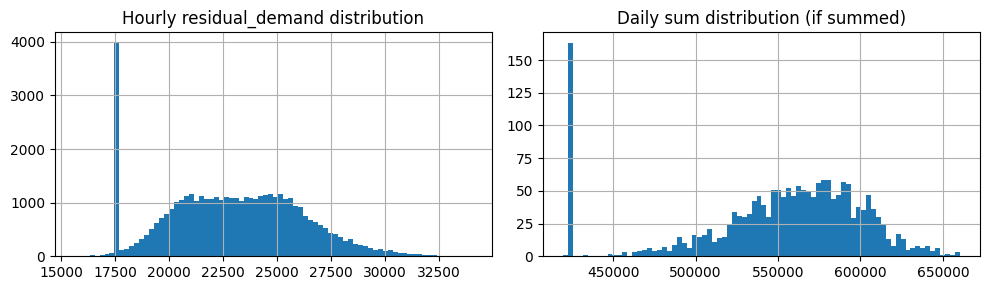

In [ ]:
# Inspect scale of target
print("Raw target summary (first 10 rows):")
print(df[['timestamp','residual_demand']].head(10))

print("\nFull describe():")
print(df['residual_demand'].describe())

# If you aggregated to daily, inspect the daily target too:
df['date'] = df['timestamp'].dt.normalize()
daily = df.groupby('date', as_index=False)['residual_demand'].sum().rename(columns={'residual_demand':'daily_sum'})
daily['daily_mean'] = df.groupby('date')['residual_demand'].mean().values
print("\nDaily sample (sum & mean):")
print(daily.head(10))

# Quick histograms to see distribution range
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
df['residual_demand'].hist(bins=80)
plt.title('Hourly residual_demand distribution')
plt.subplot(1,2,2)
daily['daily_sum'].hist(bins=80)
plt.title('Daily sum distribution (if summed)')
plt.tight_layout()
plt.show()


In [ ]:
# --------------------------
# Hourly training pipeline
# --------------------------
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import lightgbm as lgb
import xgboost as xgb
import warnings

# Optional: suppress that sklearn warning about feature names (if you prefer)
warnings.filterwarnings("ignore", message="X does not have valid feature names")

# Prepare hourly dataset: rename and ensure sorted
df = df.sort_values('timestamp').reset_index(drop=True)
df['residual_demand'] = pd.to_numeric(df['residual_demand'], errors='coerce')
df = df.dropna(subset=['residual_demand']).reset_index(drop=True)

# Create time features and hourly lag/rolling features
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

# Lag features (1 hour, 24 hours, 168 hours)
for lag in [1, 24, 168]:
    df[f'lag_{lag}'] = df['residual_demand'].shift(lag)

# Rolling means (past 3h, 24h, 168h) — shift by 1 so we don't leak current hour
for w in [3, 24, 168]:
    df[f'roll_mean_{w}'] = df['residual_demand'].shift(1).rolling(window=w, min_periods=1).mean()

# Drop rows with NaN from lags
df_model = df.dropna(subset=[f'lag_1']).reset_index(drop=True)

# Features and target
TARGET = 'residual_demand'
features = [c for c in df_model.columns if c not in ['timestamp', TARGET, 'date', 'Date Time Hour Beginning']]

# Time-ordered split: train on first 80% (respect temporal order)
split_idx = int(len(df_model) * 0.8)
X_train = df_model[features].iloc[:split_idx]
X_test  = df_model[features].iloc[split_idx:]
y_train = df_model[TARGET].iloc[:split_idx]
y_test  = df_model[TARGET].iloc[split_idx:]

print("Rows (train/test):", X_train.shape, X_test.shape)
print("Feature sample:", features)







Rows (train/test): (35058, 14) (8765, 14)
Feature sample: ['Residual Forecast', 'RSA Contracted Forecast', 'Residual Demand', 'ILS Usage', 'hour', 'weekday', 'month', 'is_weekend', 'lag_1', 'lag_24', 'lag_168', 'roll_mean_3', 'roll_mean_24', 'roll_mean_168']


In [ ]:
# Define base models (no scaling)
lgbm = lgb.LGBMRegressor(n_estimators=300, random_state=42)
xgbr = xgb.XGBRegressor(n_estimators=300, tree_method="hist", random_state=42, verbosity=0)
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

# Stack with Ridge meta model (with its own scaler)
from sklearn.pipeline import make_pipeline
stack = StackingRegressor(
    estimators=[('lgbm', lgbm), ('xgb', xgbr), ('rf', rf)],
    final_estimator=make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    n_jobs=-1,
    cv=5
)

In [ ]:
stack.fit(X_train, y_train)



StackingRegressor(cv=5,
                  estimators=[('lgbm',
                               LGBMRegressor(n_estimators=300,
                                             random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('rf',
                               RandomForestRegressor(n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))],
                  final_estimator=Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('ridge', Ridge())]),
                  n_jobs=-1)

In [ ]:
# Predict & metrics (units: MW)
y_pred = stack.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Hourly Test MAE: {mae:.2f} MW")
print(f"Hourly Test RMSE: {rmse:.2f}")
print(f"Hourly Test R2: {r2:.4f}")

Hourly Test MAE: 2282.27 MW
Hourly Test RMSE: 11666341.76
Hourly Test R2: -0.1500


In [ ]:
corrs = df_model[['residual_demand', 'lag_1', 'lag_24', 'lag_168']].corr()
print(corrs)

                 residual_demand     lag_1    lag_24   lag_168
residual_demand         1.000000  0.944792  0.923654  0.922341
lag_1                   0.944792  1.000000  0.875884  0.870488
lag_24                  0.923654  0.875884  1.000000  0.887206
lag_168                 0.922341  0.870488  0.887206  1.000000


In [ ]:
models = {
    'LGBM': lgb.LGBMRegressor(n_estimators=300, random_state=42),
    'XGB': xgb.XGBRegressor(n_estimators=300, random_state=42, verbosity=0),
    'RF': RandomForestRegressor(n_estimators=200, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(name,
          'MAE:', mean_absolute_error(y_test, preds),
          'R2:', r2_score(y_test, preds))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 35058, number of used features: 14
[LightGBM] [Info] Start training from score 23613.390821
LGBM MAE: 162.06452841781905 R2: 0.9932946236915059
XGB MAE: 6182.511392439748 R2: -7.412596108532185
RF MAE: 2311.441844971272 R2: -0.17972287077387716


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 35058, number of used features: 14
[LightGBM] [Info] Start training from score 23613.390821


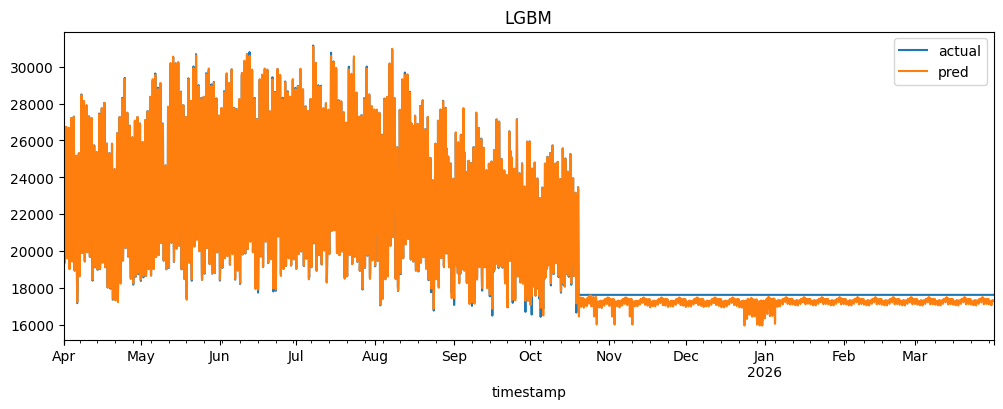

LGBM MAE: 162.06452841781905 R2: 0.9932946236915059




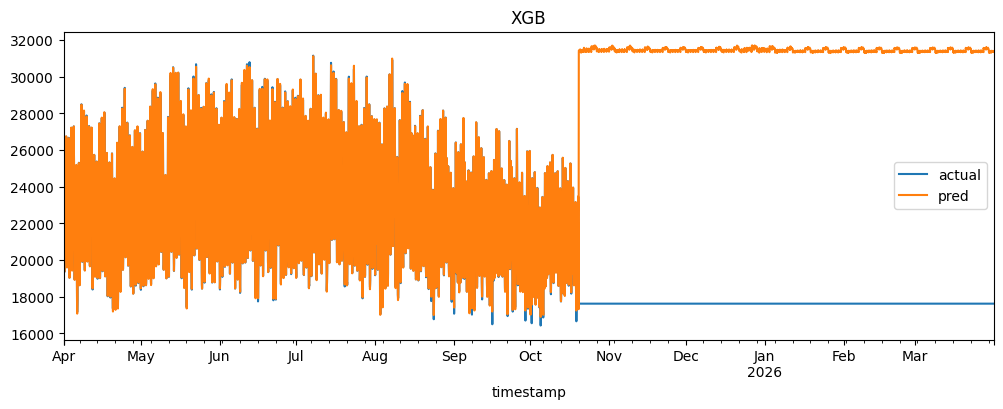

XGB MAE: 6182.511392439748 R2: -7.412596108532185




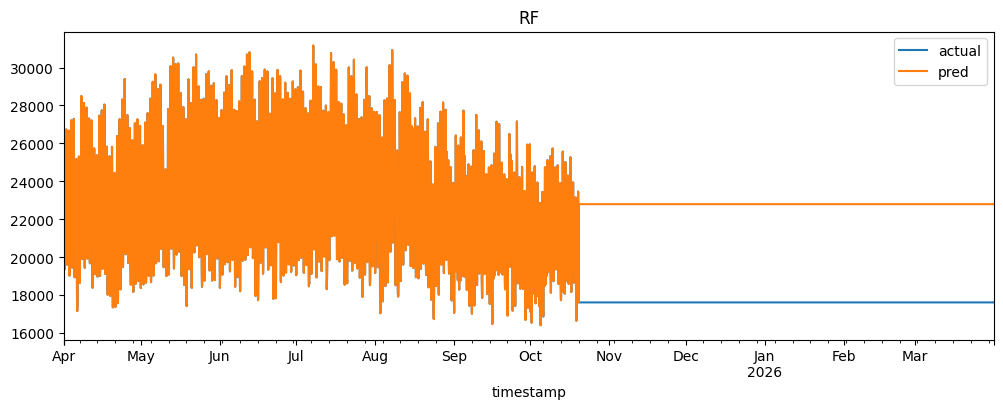

RF MAE: 2311.441844971272 R2: -0.17972287077387716




In [ ]:
# make line graphs of the actual vs predicted for each model
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    comp = pd.DataFrame({'timestamp': df_model.loc[X_test.index, 'timestamp'].values, 'actual': y_test.values, 'pred': preds})
    comp.set_index('timestamp', inplace=True)
    comp[['actual','pred']].plot(figsize=(12,4));
    plt.title(name)
    plt.show()
    print(name,
          'MAE:', mean_absolute_error(y_test, preds),
          'R2:', r2_score(y_test, preds))
    print()
    print()

Train MAE: 0.1550860789462492
Train R2:  0.9999995943990531
Test  MAE: 2311.441844971272
Test  R2:  -0.17972287077387716
Naive lag-1 MAE: 548.8406725613233 R2: 0.9202038450476471
TS CV MAE mean: 527.888461958394 R2 mean: 0.7242998312212101


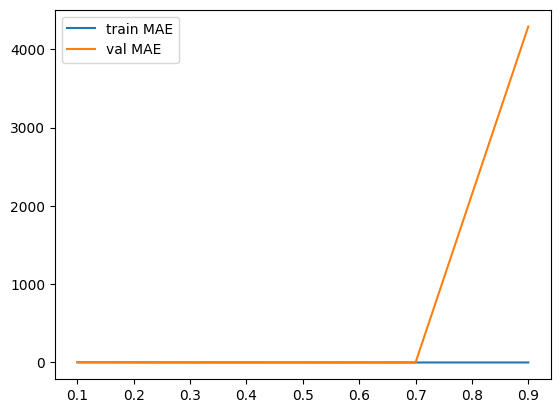

In [ ]:
# assumes: df_model (sorted by timestamp), features list, TARGET, stack or lgbm model object (model)
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# 1A. Train vs test metrics (explicit)
# If you trained 'lgbm' on X_train/y_train and have X_test/y_test and preds:
print("Train MAE:", mean_absolute_error(y_train, model.predict(X_train)))
print("Train R2: ", r2_score(y_train, model.predict(X_train)))
print("Test  MAE:", mean_absolute_error(y_test, model.predict(X_test)))
print("Test  R2: ", r2_score(y_test, model.predict(X_test)))

# 1B. Naive lag-1 baseline
naive_pred = X_test['lag_1'].values
print("Naive lag-1 MAE:", mean_absolute_error(y_test, naive_pred),
      "R2:", r2_score(y_test, naive_pred))

# 1C. TimeSeries cross-validation (walk-forward) - get CV scores
tscv = TimeSeriesSplit(n_splits=5)
maes=[]
r2s=[]
for train_idx, val_idx in tscv.split(df_model):
    Xtr, Xval = df_model.iloc[train_idx][features], df_model.iloc[val_idx][features]
    ytr, yval = df_model.iloc[train_idx][TARGET], df_model.iloc[val_idx][TARGET]
    m = model.__class__(**model.get_params())  # refit fresh
    m.fit(Xtr, ytr)
    p = m.predict(Xval)
    maes.append(mean_absolute_error(yval,p)); r2s.append(r2_score(yval,p))
print("TS CV MAE mean:", np.mean(maes), "R2 mean:", np.mean(r2s))

# 1D. Learning curve (train size vs error)
train_sizes = np.linspace(0.1,0.9,5)
train_err=[]; val_err=[]
for frac in train_sizes:
    idx = int(len(df_model)*frac)
    Xtr, Xval = df_model[features].iloc[:idx], df_model[features].iloc[idx:int(idx + 0.2*len(df_model))]
    ytr, yval = df_model[TARGET].iloc[:idx], df_model[TARGET].iloc[idx:int(idx + 0.2*len(df_model))]
    m = model.__class__(**model.get_params()); m.fit(Xtr,ytr)
    train_err.append(mean_absolute_error(ytr, m.predict(Xtr)))
    val_err.append(mean_absolute_error(yval, m.predict(Xval)))
plt.plot(train_sizes, train_err, label='train MAE'); plt.plot(train_sizes, val_err, label='val MAE'); plt.legend(); plt.show()


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# Time-ordered split
split = int(len(df_model) * 0.8)
Xtr, Xval = df_model[features].iloc[:split], df_model[features].iloc[split:]
ytr, yval = df_model[TARGET].iloc[:split], df_model[TARGET].iloc[split:]

lgbm_reg = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    num_leaves=20,          # simpler trees
    max_depth=8,            # limit depth
    min_data_in_leaf=100,   # require more samples per leaf
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=2.0,
    random_state=42
)

lgbm_reg.fit(
    Xtr, ytr,
    eval_set=[(Xval, yval)],
    eval_metric='mae',
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=50)]
)

preds = lgbm_reg.predict(Xval)
print("Val MAE:", mean_absolute_error(yval, preds))
print("Val R2:", r2_score(yval, preds))

joblib.dump(lgbm_reg, "energy_model_eskom_regularized.joblib")
print("✅ Saved model: energy_model_eskom_regularized.joblib")

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 35058, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 23613.390821
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, b

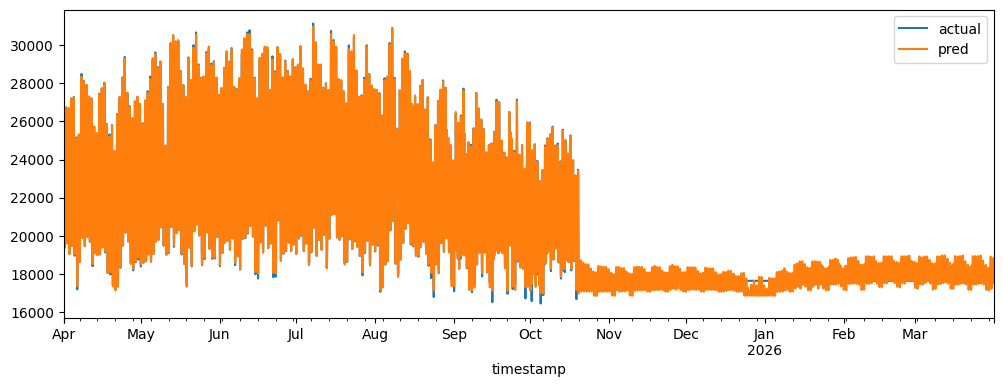

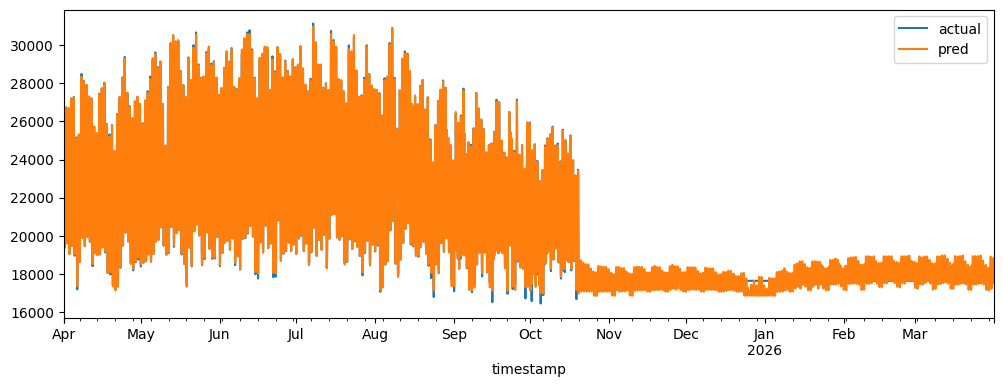

In [ ]:
#  make line graphs of the actual vs predicted for the lgbm model
comp = pd.DataFrame({'timestamp': df_model.loc[X_test.index, 'timestamp'].values, 'actual': y_test.values, 'pred': preds})
comp.set_index('timestamp', inplace=True)
comp[['actual','pred']].plot(figsize=(12,4));
plt.show()

# make it more visible
comp.plot(figsize=(12,4));
plt.show()

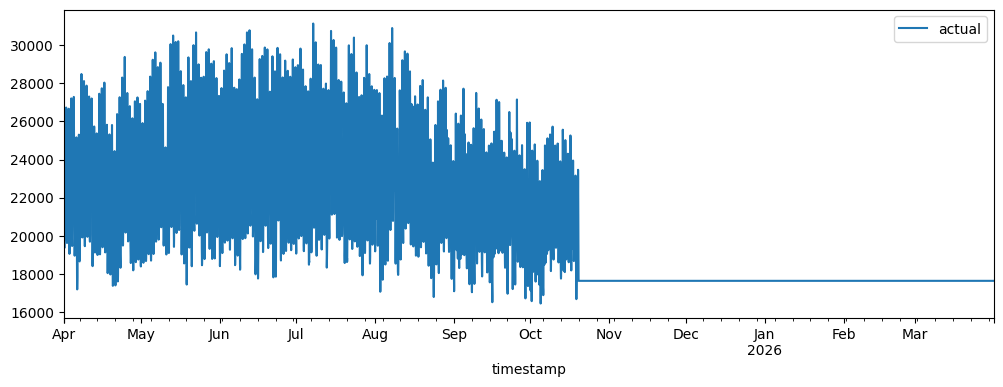

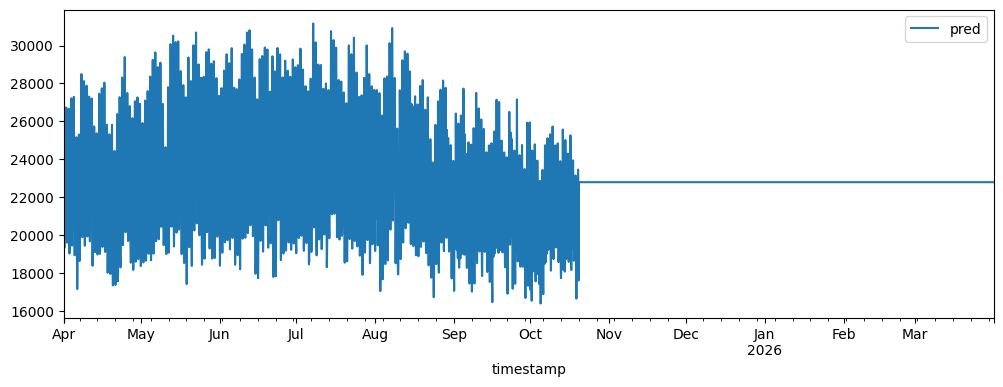

In [ ]:
# show the line graph for the actual and the predicted of the lgbm separately
comp[['actual']].plot(figsize=(12,4));
comp[['pred']].plot(figsize=(12,4));
plt.show()


In [ ]:
# Save pipeline
OUT = 'energy_model_eskom_hourly.joblib'
joblib.dump(pipeline, OUT)
print("Saved model:", OUT)